# Chi-Squared Calculation Comparison

This notebook compares the Chi-Squared values returned by SNCosmo against Chi-Squared values calculated by the analysis pipeline.

In [1]:
import sys
from warnings import warn

import numpy as np
import sncosmo
from SNData.csp import dr3
from SNData.des import sn3yr
from astropy.table import Table, join
from matplotlib import pyplot as plt

sys.path.insert(0, '../')
from analysis_pipeline import get_fit_results, get_priors, SN91bgSource, calc_chisq

for module in (dr3, sn3yr):
    module.download_module_data()
    module.register_filters(force=True)


## Fitting with All Data

We begin by considering chi-squared values calculated from fits using all available band data. We arbitrarily pick a target from the CSP DR3 data release and fit it's light curve with the Salt2.4 model.

/anaconda3/envs/sdss_class/lib/python3.7/site-packages/sncosmo/fitting.py:158: RuntimeWarning: Dropping following bands from data: csp_dr3_Y, csp_dr3_J, csp_dr3_H, csp_dr3_Ydw(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


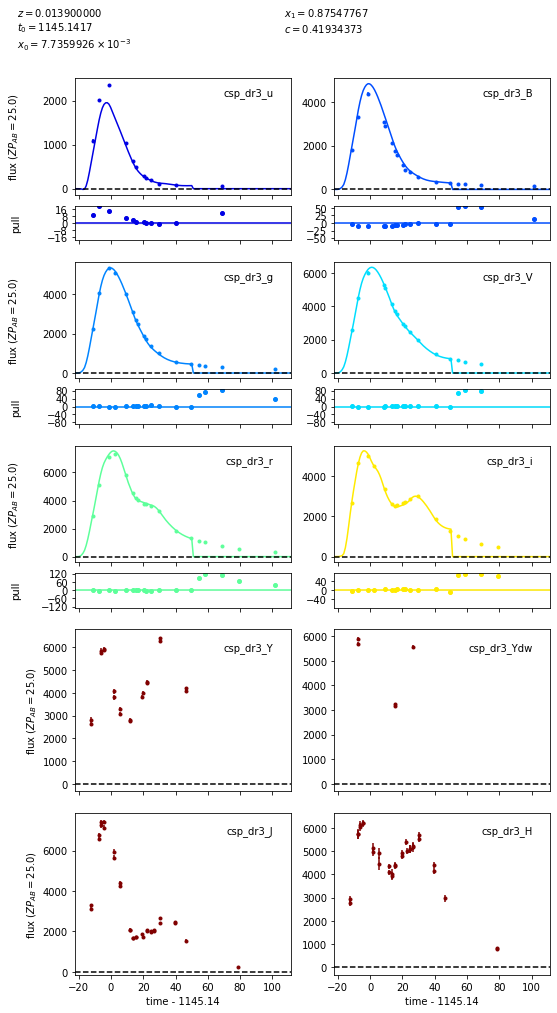

In [2]:
test_id = '2007S'
model = sncosmo.Model('salt2')
data = dr3.get_data_for_id(test_id, format_sncosmo=True)
priors = get_priors(dr3, model).loc[test_id]

model.set(z=data.meta['redshift'])
bounds = dict()
for p in model.param_names:
    bounds[p] = (priors[f'{p}_min'], priors[f'{p}_max'])
    model.update({p: priors[p]})

fit_result, fit_model = sncosmo.fit_lc(data, model, ['t0', 'x0', 'x1', 'c'], bounds=bounds, phase_range=(-20,50))
sncosmo.plot_lc(data, fit_model)
plt.show()


Next we compare the various chi-squared values.

In [3]:
sncosmo_chisq = fit_result['chisq'] / fit_result['ndof']
print('Chi-Squared from fit_lc:', sncosmo_chisq)

pipeline_data = get_fit_results(dr3, model, 4)[0].loc[test_id]
print('Pipeline Chi-squared using all data:', 
      pipeline_data['chi'] / pipeline_data['dof'])


Chi-Squared from fit_lc: 24.003909841485793
Pipeline Chi-squared using all data: 25.0986792071502


Self-implemented lc-fitting plots for clarity.

In [ ]:
allbands = data.copy()

fig = plt.figure(figsize=(10,12))
ax = [plt.subplot(3, 2, i + 1) for i in range(6)]

b = ['csp_dr3_u', 'csp_dr3_B', 'csp_dr3_g', 'csp_dr3_V', 'csp_dr3_r', 'csp_dr3_i']
plot_color = ['darkblue', 'blue', 'aqua', 'lightblue', 'lightgreen', 'yellow']
for i in range(6):
    data = allbands.copy()
    data = data[data['band'] == b[i]]
    ax[i].errorbar(data['time'], data['flux'], yerr=data['fluxerr'], fmt='.', markersize=3, capsize=2)
    xtime = np.arange(data['time'].min(), data['time'].max(),0.1)
    yflux = [fit_model.bandflux(data['band'][0], t) for t in xtime]
    ax[i].plot(xtime, yflux, c=plot_color[i], label=b[i])
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Flux')
    ax[i].legend()


## Fitting Individual Bands

In addition to fitting all available bands at once, we also fit individual band passes and look at the chi-squared values summed over the individual bands.

In [5]:
band_sncosmo_chisq = dict()
band_pipeline_chisq = dict()
for band in set(data['band']):
    band_data = data[data['band'] == band]
    vparams=['t0', 'x0', 'x1', 'c']
    try:
        snc_result, fitted_model = sncosmo.fit_lc(band_data, model, vparams, phase_range=(-15,50))
        
    except RuntimeError:
        continue
    
    
    # Calculate chi-squared
    pipe_chisq, num_points = calc_chisq(band_data, fitted_model)
    pipe_dof = len(band_data) - len(vparams)
    band_pipeline_chisq[band] = pipe_chisq / pipe_dof
    band_sncosmo_chisq[band] = snc_result['chisq'] / snc_result['ndof']

print('SNCosmo Chi-Squared:')
print(band_sncosmo_chisq)

print('\nSNCosmo Chi-Squared summed over bands:')
print(sum(i for i in band_sncosmo_chisq.values()))

print('\nPipeline Chi-Squared:')
print(band_pipeline_chisq)

print('\nPipeline Chi-Squared summed over bands:')
print(sum(i for i in band_pipeline_chisq.values()))


SNCosmo Chi-Squared:
{'csp_dr3_V': 0.640924085217729, 'csp_dr3_r': 5.634601474431106, 'csp_dr3_u': 1.1057966396195067, 'csp_dr3_i': 6.984323381945437, 'csp_dr3_g': 2.6893524327981075, 'csp_dr3_B': 1.4543085251722399}

SNCosmo Chi-Squared summed over bands:
18.509306539184127

Pipeline Chi-Squared:
{'csp_dr3_V': 6.9087817304994, 'csp_dr3_r': 4.073788194352209, 'csp_dr3_u': 10.428271289281323, 'csp_dr3_i': 5.108084955243093, 'csp_dr3_g': 7.430971018160718, 'csp_dr3_B': 65.29441948586444}

Pipeline Chi-Squared summed over bands:
99.24431667340119
